# Challenge Description

We have data about users who hit our site: whether they converted or not as well as some of their characteristics such as their country, the marketing channel, their age, whether they are repeat users and the number of pages visited during that session (as a proxy for site activity/time spent on site).


Your project is to:

1. Predict conversion rate


2. Come up with recommendations for the product team and the marketing team to improve conversion rate

# 1. Begin Analyzing

## 1.1 Explore the Dataset


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
from pyecharts.charts import Bar,Pie,Grid,Line
from pyecharts import options as opts
import pyecharts

In [2]:
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = f"{name}-{x}"
        df[dummy_name] = dummies[x]
    #df.drop(name, axis=1, inplace=True)

In [3]:
df = pd.read_csv('./conversion_data.csv',index_col=False)

In [4]:
# Take a look at the first 5 rows:
df.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [5]:
# How many records do we have:
df.shape

(316200, 6)

In [6]:
# Are there any missing values:
df.isna().any()

country                False
age                    False
new_user               False
source                 False
total_pages_visited    False
converted              False
dtype: bool

In [7]:
# Encode Country
encode_text_dummy(df, 'country')
encode_text_dummy(df, 'source')

In [8]:
# Get some statistics out of the dataset
df.describe()

,age,new_user,total_pages_visited,converted,country-China,country-Germany,country-UK,country-US,source-Ads,source-Direct,source-Seo
count,316200.000000,316200.000000,316200.000000,316200.000000,316200.000000,316200.000000,316200.000000,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258,0.242258,0.041290,0.153226,0.563226,0.280645,0.229032,0.490323
std,8.271802,0.464331,3.341104,0.176685,0.428450,0.198961,0.360206,0.495987,0.449315,0.420211,0.499907
min,17.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000
max,123.000000,1.000000,29.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## 1.2 Explanatory Data Analysis

### 1.2.1 Convertion in Different Countries

In [9]:
grouped_non = df.loc[df['converted']==0].groupby('country')['converted'].count().reset_index()
grouped_converted = df.loc[df['converted']==1].groupby('country')['converted'].count().reset_index()

In [10]:
attr = grouped_converted['country'].to_list()
v1 = np.log10(grouped_non['converted']).round(2).to_list()
v2 = np.log10(grouped_converted['converted']).round(2).to_list()
bar2 = (Bar().
        add_xaxis(attr)
        .add_yaxis("Not Converted",v1)
        .add_yaxis("Converted",v2)
        .set_global_opts(title_opts=opts.TitleOpts(title="Convert Log Count")))
bar2.render_notebook()

In [177]:
grouped = df[['age', 'converted']].groupby('age').mean().reset_index()

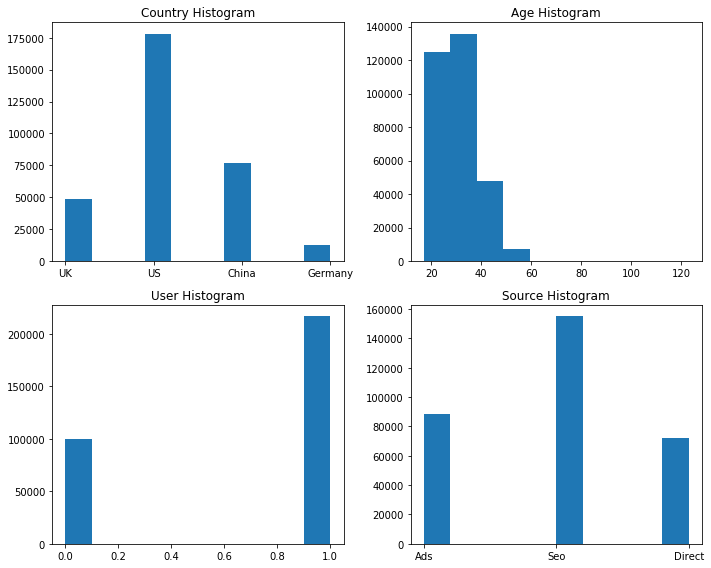

In [158]:
%matplotlib inline
fig, axes = plt.subplots(2, 2, figsize=(10,8))
#f, (ax1, ax2, ax3, ax4) = plt.subplots(2, 3, sharey=True, figsize=(10,3))

axes[0,0].hist(df['country'],)
axes[0,0].set_title("Country Histogram")

axes[0,1].hist(df['age'],)
axes[0,1].set_title("Age Histogram")

axes[1,0].hist(df['new_user'],)
axes[1,0].set_title("User Histogram")

axes[1,1].hist(df['source'],)
axes[1,1].set_title("Source Histogram")

fig.tight_layout()

In [88]:
df['convert_rate'] = df['converted'] / df['total_pages_visited']

### Closer Look at Convertion Rate

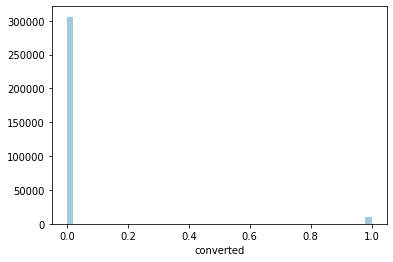

In [85]:
# Distplot of Convert
sns.distplot(df['converted'], kde=False)

In [89]:
df['convert_rate'].describe()

count    316200.000000
mean          0.002440
std           0.014458
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           0.500000
Name: convert_rate, dtype: float64

- ### Country

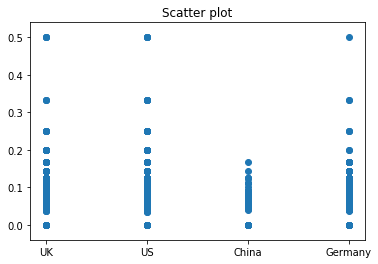

In [94]:
plt.scatter(df['country'], df['convert_rate'])
plt.title('Scatter plot')
plt.show()

   country  convert_rate
0    China      0.000099
1  Germany      0.004752
2       UK      0.003988
3       US      0.002857


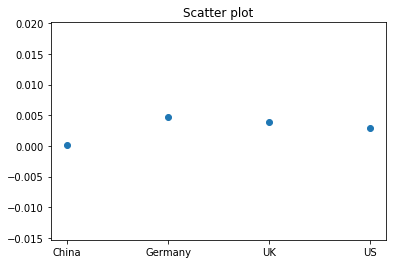

In [108]:
# Mean conversion rate across contries
df_country = df[['country','convert_rate']].groupby('country')\
['convert_rate'].mean().reset_index()
print(df_country)
plt.scatter(df_country['country'], df_country['convert_rate'])
plt.title('Scatter plot')
plt.show()

## China has lowest conversion rate

- ### Age

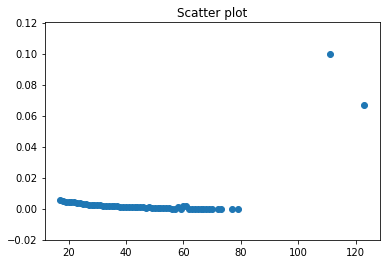

In [104]:
# Mean conversion rate across ages

df_age = df[['age','convert_rate']].groupby('age')\
['convert_rate'].mean().reset_index()
plt.scatter(df_age['age'], df_age['convert_rate'])
plt.title('Scatter plot')
plt.show()

In [179]:
df = df.loc[df['age']<100]

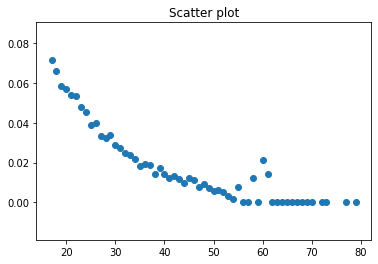

In [183]:
# Mean conversion rate across ages

df_age = df[['age','converted']].groupby('age')\
['converted'].mean().reset_index()
plt.scatter(df_age['age'], df_age['converted'])
plt.title('Scatter plot')
plt.show()

- ### New User

   new_user  convert_rate
0         0      0.005460
1         1      0.001055


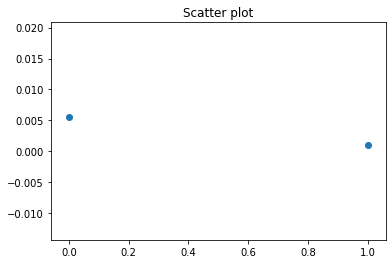

In [109]:
# Mean conversion rate between new users and old users

df_ = df[['new_user','convert_rate']].groupby('new_user')\
['convert_rate'].mean().reset_index()
print(df_)
plt.scatter(df_['new_user'], df_['convert_rate'])
plt.title('Scatter plot')
plt.show()

## New users have lower conversion rate

- ### Source

   source  convert_rate
0     Ads      0.002600
1  Direct      0.002135
2     Seo      0.002492


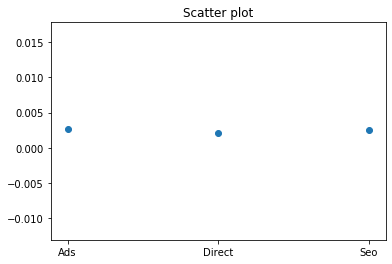

In [110]:
# Mean conversion rate across sources
df_ = df[['source','convert_rate']].groupby('source')\
['convert_rate'].mean().reset_index()
print(df_)
plt.scatter(df_['source'], df_['convert_rate'])
plt.title('Scatter plot')
plt.show()

## Conversion rate about the same

## Problem Setup

We should predict whether this person is going to convert or not and divide that with total number of visit to calculate the conversion rate. Thus, we can regard convert or not for one instance as Bernoulli problem. 

We can try Logistic Regression, KNN, Random Forest.

Since lots of cases are not converted, we can use confusion matrix to evaluate model.

In [127]:
df_final = df.drop(columns=['country','source','convert_rate'])
y = df_final['converted'].values
df_final.drop(columns='converted',inplace=True)
X = df_final.values
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [128]:
np.random.seed(42)
# Logistic Regression
classifier_logistic = LogisticRegression()
# K Nearest Neighbors
classifier_KNN = KNeighborsClassifier()
# Random Forest
classifier_RF = RandomForestClassifier()

Logistic Regression
Accuracy is: 0.986
precision is: 0.842
recall is: 0.692


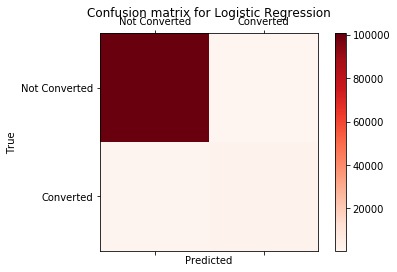

KNN
Accuracy is: 0.985
precision is: 0.818
recall is: 0.669


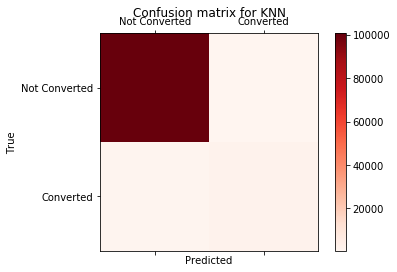

Random Forest
Accuracy is: 0.984
precision is: 0.799
recall is: 0.676


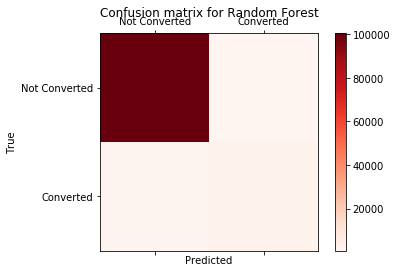

In [141]:
%matplotlib inline

# calculate accuracy, precision and recall
def cal_evaluation(classifier, cm):
    tn = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tp = cm[1][1]
    accuracy  = (tp + tn) / (tp + fp + fn + tn + 0.0)
    precision = tp / (tp + fp + 0.0)
    recall = tp / (tp + fn + 0.0)
    print (classifier)
    print ("Accuracy is: %0.3f" % accuracy)
    print ("precision is: %0.3f" % precision)
    print ("recall is: %0.3f" % recall)

# print out confusion matrices
def draw_confusion_matrices(confusion_matricies):
    class_names = ['Not Converted','Converted']
    for cm in confusion_matrices:
        classifier, cm = cm[0], cm[1]
        cal_evaluation(classifier, cm)
        fig = plt.figure()
        ax = fig.add_subplot(111)
        cax = ax.matshow(cm, interpolation='nearest',cmap=plt.get_cmap('Reds'))
        plt.title('Confusion matrix for %s' % classifier)
        fig.colorbar(cax)
        ax.set_xticklabels([''] + class_names)
        ax.set_yticklabels([''] + class_names)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()
        
        
classifier_logistic.fit(X_train, y_train)
pred_log = classifier_logistic.predict(X_test)

classifier_KNN.fit(X_train, y_train)
pred_knn = classifier_KNN.predict(X_test)

classifier_RF.fit(X_train, y_train)
pred_rf = classifier_RF.predict(X_test)

# Confusion matrix, accuracy, precison and recall for random forest and logistic regression
confusion_matrices = [
    ("Logistic Regression", confusion_matrix(y_test,pred_log)),
    ("KNN", confusion_matrix(y_test,pred_knn)),
    ("Random Forest", confusion_matrix(y_test,pred_rf)),
]
#confusion_matrices
draw_confusion_matrices(confusion_matrices)

In [145]:
# Take a look at F1-Score
from sklearn.metrics import f1_score
f1score = [
    ("Logistic Regression", f1_score(y_test,pred_log)),
    ("KNN", f1_score(y_test,pred_knn)),
    ("Random Forest", f1_score(y_test,pred_rf)),
]
f1score

[('Logistic Regression', 0.759785881565741),
 ('KNN', 0.7359946326735993),
 ('Random Forest', 0.7324966974900924)]

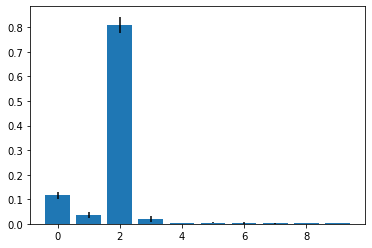

In [168]:
importance = classifier_RF.feature_importances_
importance = pd.DataFrame(importance, index=df_final.columns, 
                          columns=["Importance"])

importance["Std"] = np.std([tree.feature_importances_
                            for tree in classifier_RF.estimators_], axis=0)

x = range(importance.shape[0])
y = importance.ix[:, 0]
yerr = importance.ix[:, 1]
bars = df_final.columns.to_list()
plt.bar(x, y, yerr=yerr, align="center")
#plt.xticks(x, bars)
plt.show()

In [166]:
range(0,importance.shape[0]**2,10)

range(0, 100, 10)

In [169]:
bars

['age',
 'new_user',
 'total_pages_visited',
 'country-China',
 'country-Germany',
 'country-UK',
 'country-US',
 'source-Ads',
 'source-Direct',
 'source-Seo']